In [1]:
import jax
from jax.lib import xla_bridge

print("Default backend:", xla_bridge.get_backend().platform)
print("All devices:", jax.devices())

/tmp/ipykernel_1509/4202943089.py:4: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print("Default backend:", xla_bridge.get_backend().platform)


Default backend: gpu
All devices: [CudaDevice(id=0)]


# Model ⇨ System Conversion

### Imports & File Path

In [2]:
import pathlib
import mujoco          # MuJoCo >= 3.1
import brax
from brax.io import mjcf
import jax.numpy as jnp
from IPython.display import Markdown, display


# Path to your XML file (relative or absolute)
from passive_walker.constants import XML_PATH
from passive_walker.brax import DATA_BRAX
assert XML_PATH.exists(), f'XML file not found: {XML_PATH.resolve()}'

### Load XML with MuJoCo & Convert to Brax System

In [3]:
# Load into a raw MuJoCo model
mj_model = mujoco.MjModel.from_xml_path(str(XML_PATH))

# Convert MuJoCo model → Brax System (JAX‑native datastructure)
walker_sys = mjcf.load_model(mj_model)

print('MuJoCo XML successfully loaded and converted to Brax System')

MuJoCo XML successfully loaded and converted to Brax System


There were some problem with my XML file and following code ensures len(sys.link_types) == len(sys.link_names) 

In [4]:
def fix_link_types(sys: brax.System) -> brax.System:

    if len(sys.link_types) == len(sys.link_names):
        print("  No patch needed: 'link_types' and 'link_names' match")
        print(f"  No patch needed: '{sys.link_types}'")
        print(f"  No patch needed: '{sys.link_names}'")
        return sys                      # nothing to do

    if len(sys.link_types) == len(sys.link_names) - 1:
        print(f"  Patching link names: '{sys.link_names}'")
        print(f"  Patching link_types: '{sys.link_types}'")

        fixed = sys.replace(link_types=sys.link_types[0] + sys.link_types)
        print(f"  Patched link names: '{fixed.link_names}'")
        print(f"  Patched link_types: '{sys.link_types}' ➜ '{fixed.link_types}'")
        return fixed

    raise ValueError(
        f"Unexpected link_types mismatch: {len(sys.link_types)} vs {len(sys.link_names)}"
    )

walker_sys = fix_link_types(walker_sys)

  No patch needed: 'link_types' and 'link_names' match
  No patch needed: '31111'
  No patch needed: '['torso', 'left_leg', 'left_foot', 'right_leg', 'right_foot']'


### System Summary

In [5]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from IPython.display import display, Markdown

def summarize_brax_system(sys, *, style='html'):
    """
    Pretty‑prints a Brax System and returns DataFrames for joints, actuators
    and bodies.  Pass style='df' to skip notebook display and just get the
    dataframes.

    Returns
    -------
    (joints_df, actuators_df, bodies_df)
    """
    
    # helpers 
    joint_type_map = {0:'free', 1:'ball', 2:'slide', 3:'hinge', 4:'weld'}
    names_blob = sys.names
    _get_name = lambda off: names_blob[off:].split(b'\x00',1)[0].decode()
    body_names = ['world'] + list(sys.link_names)

    # tilt of gravity vector wrt −Z (deg)
    tilt = float(jnp.degrees(jnp.arctan2(-sys.gravity[0], sys.gravity[2])))

    # joints table 
    joints_df = pd.DataFrame({
        'idx'     : np.arange(sys.njnt),
        'type'    : [joint_type_map.get(int(t), '?') for t in sys.jnt_type],
        'name'    : [_get_name(int(o)) for o in sys.name_jntadr],
        'body'    : [body_names[int(b)] for b in sys.jnt_bodyid],
        'axis'    : [tuple(a.tolist()) for a in sys.jnt_axis],
        'limited' : sys.jnt_limited.astype(bool),
        'lo'      : sys.jnt_range[:,0],
        'hi'      : sys.jnt_range[:,1],
    })

    # actuators table
    # map each actuator's q_id to a joint index
    q_to_joint = {int(qp):idx for idx, qp in enumerate(sys.jnt_qposadr)}
    rows = []
    for i,(lo,hi) in enumerate(sys.actuator.ctrl_range):
        qid   = int(sys.actuator.q_id[i])
        jidx  = q_to_joint[qid]
        rows.append(dict(
            idx       = i,
            name      = _get_name(int(sys.name_actuatoradr[i]))
                        if hasattr(sys,'name_actuatoradr') else f'act_{i}',
            joint     = joints_df.loc[jidx,'name'],
            body      = joints_df.loc[jidx,'body'],
            ctrl_lo   = lo,
            ctrl_hi   = hi,
            unit      = 'rad' if i==0 else 'm',
        ))
    actuators_df = pd.DataFrame(rows)
    
    # bodies table 
    bodies_df = pd.DataFrame({
        'idx'   : np.arange(len(sys.link_names)),
        'name'  : sys.link_names,
        'parent': ['world' if p == -1 else sys.link_names[p]
                for p in sys.link_parents],                               
        'mass'  : sys.link.inertia.mass,
        'inertia': [tuple(np.diag(I)) for I in sys.link.inertia.i],
    })


    # display in notebooks 
    if style=='html':
        display(Markdown('## ⟪ Brax System Summary ⟫'))
        print('‾'*45)
        print(f' bodies           : {sys.link_names}')
        print(f' nq | nv | nu     : {sys.nq} | {sys.nv} | {sys.nu}')
        print(f' gravity tilt     : {tilt:+.1f} deg')

        display(Markdown('### Bodies'));     display(bodies_df.style.hide(axis="index"))
        display(Markdown('### Joints'));     display(joints_df.style.hide(axis="index"))
        display(Markdown('### Actuators'));  display(actuators_df.style.hide(axis="index"))

    return joints_df, actuators_df, bodies_df


In [6]:
summarize_brax_system(walker_sys)

## ⟪ Brax System Summary ⟫

‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
 bodies           : ['torso', 'left_leg', 'left_foot', 'right_leg', 'right_foot']
 nq | nv | nu     : 7 | 7 | 3
 gravity tilt     : -180.0 deg


### Bodies

idx,name,parent,mass,inertia
0,torso,world,5.000000,"(0.02, 0.02, 0.02)"
1,left_leg,torso,1.000000,"(0.09557031, 0.09557031, 0.001234375)"
2,left_foot,left_leg,0.100000,"(1e-04, 1e-04, 1e-04)"
3,right_leg,torso,1.000000,"(0.09557031, 0.09557031, 0.001234375)"
4,right_foot,right_leg,0.100000,"(1e-04, 1e-04, 1e-04)"


### Joints

idx,type,name,body,axis,limited,lo,hi
0,slide,slide_x,torso,"(1.0, 0.0, 0.0)",False,-inf,inf
1,slide,slide_z,torso,"(0.0, 0.0, 1.0)",False,-inf,inf
2,hinge,yaw,torso,"(0.0, 1.0, 0.0)",False,-inf,inf
3,hinge,left_leg_lock,left_leg,"(1.0, 0.0, 0.0)",True,0.000000,0.000175
4,slide,left_knee,left_foot,"(0.0, 0.0, -1.0)",True,-0.300000,0.300000
5,hinge,hip,right_leg,"(0.0, -1.0, 0.0)",False,-inf,inf
6,slide,right_knee,right_foot,"(0.0, 0.0, -1.0)",True,-0.300000,0.300000


### Actuators

idx,name,joint,body,ctrl_lo,ctrl_hi,unit
0,hip_act,hip,right_leg,-0.5,0.5,rad
1,left_knee_act,left_knee,left_foot,-0.3,0.3,m
2,right_knee_act,right_knee,right_foot,-0.3,0.3,m


(   idx   type           name        body              axis  limited   lo  \
 0    0  slide        slide_x       torso   (1.0, 0.0, 0.0)    False -inf   
 1    1  slide        slide_z       torso   (0.0, 0.0, 1.0)    False -inf   
 2    2  hinge            yaw       torso   (0.0, 1.0, 0.0)    False -inf   
 3    3  hinge  left_leg_lock    left_leg   (1.0, 0.0, 0.0)     True  0.0   
 4    4  slide      left_knee   left_foot  (0.0, 0.0, -1.0)     True -0.3   
 5    5  hinge            hip   right_leg  (0.0, -1.0, 0.0)    False -inf   
 6    6  slide     right_knee  right_foot  (0.0, 0.0, -1.0)     True -0.3   
 
          hi  
 0       inf  
 1       inf  
 2       inf  
 3  0.000175  
 4  0.300000  
 5       inf  
 6  0.300000  ,
    idx            name       joint        body ctrl_lo ctrl_hi unit
 0    0         hip_act         hip   right_leg    -0.5     0.5  rad
 1    1   left_knee_act   left_knee   left_foot    -0.3     0.3    m
 2    2  right_knee_act  right_knee  right_foot    -0.

In [7]:
# show raw MuJoCo codes next to the names we print
for idx, (code, name_off) in enumerate(zip(walker_sys.jnt_type, walker_sys.name_jntadr)):
    print(idx, int(code), name_off, walker_sys.names[name_off:].split(b'\0',1)[0])

0 2 83 b'slide_x'
1 2 91 b'slide_z'
2 3 99 b'yaw'
3 3 103 b'left_leg_lock'
4 2 117 b'left_knee'
5 3 127 b'hip'
6 2 131 b'right_knee'


> **Gravity check:** MuJoCo encodes an 11.5° downhill slope by tilting the
> gravity vector to **( 1.95, 0, –9.61 )m/s²**.  No physical ramp geom is
> present; the walker “falls” forward automatically.  If you prefer a flat
> world, change the `<option gravity="0 0 -9.81">` line in the XML and
> re‑run Cell A‑2.

In [8]:
# Ensure mass & inertia arrays are finite and positive
assert np.all(np.isfinite(walker_sys.link.inertia.i)), 'non‑finite inertia detected'
assert np.all(walker_sys.link.inertia.mass > 0), 'link with zero/neg mass detected'

print(' Basic numeric sanity checks passed.')
print('-------------------------------------------')

 Basic numeric sanity checks passed.
-------------------------------------------


In [9]:
import pickle, gzip

OUT = DATA_BRAX / "passiveWalker_brax_system.pkl.gz"
with gzip.open(OUT, 'wb') as f:
    pickle.dump(walker_sys, f)
print(f' System pickled to: {OUT.resolve()}')
print('-------------------------------------------')

 System pickled to: /home/yunusdanabas/passive_walker_rl/data/brax/passiveWalker_brax_system.pkl.gz
-------------------------------------------


# BraxPassiveWalker Environment

### Imports and sys reload 

In [10]:
import jax
import jax.numpy as jnp

from brax.envs.base    import PipelineEnv, State
from brax.v1.physics.base import QP
from IPython.display   import HTML, display

### Environment Class Definition

In [11]:
class BraxPassiveWalker(PipelineEnv):
    """
    Simple PD‑controlled biped walker (hip + two knees) converted from MuJoCo XML.
    * Action ∈ [‑1,1]^3, scaled to physical ranges inside the class.
    * Reward = forward progress (Δx).  Episode ends if torso falls below 0.5 m
      or pitch exceeds ±0.8 rad.
    """
    def __init__(self,
                 sys: brax.System,
                 kp: jnp.ndarray = jnp.array([  5.0, 1000.0, 1000.0]),
                 kd: jnp.ndarray = jnp.array([  0.5,   50.0,   50.0]),
                 reset_noise: float = 0.1):
        super().__init__(sys=sys, backend='positional')

        self.act_idx      = sys.actuator.q_id            # [hip, knees]
        self.kp, self.kd  = kp, kd
        self.action_scale = jnp.array([0.5, 0.3, 0.3])   # rad, m, m
        self.reset_noise  = reset_noise

        self.obs_size     = 2 + 1 + 2 + 3 + 3   # (see _get_obs)
        self.act_size     = 3

    # ---------- helpers ---------------------------------------------------
    def _get_obs(self, ps: brax.base.State) -> jnp.ndarray:
        torso_euler = brax.math.quat_to_euler(ps.x.rot[0])  # xyz order
        return jnp.concatenate([
            ps.x.pos[0, (0, 2)],          # x, z
            torso_euler[1:2],             # pitch
            ps.xd.vel[0, (0, 2)],         # ẋ, ż
            ps.q[self.act_idx],           # joint pos
            ps.qd[self.act_idx],          # joint vel
        ])

    # ---------- API -------------------------------------------------------
    def reset(self, rng: jax.Array):
        qd_dim = int(self.sys.qd_size())
        q  = self.sys.init_q.copy()
        qd = jnp.zeros(qd_dim)

        # small uniform noise on the three actuated joints
        rng, sub = jax.random.split(rng)
        q_noise  = self.reset_noise * (2.*jax.random.uniform(sub, (3,)) - 1.)
        q = q.at[self.act_idx].set(q_noise * self.action_scale)

        ps = self.pipeline_init(q, qd)          # now uses generalized pipeline
        return brax.envs.base.State(            # same namedtuple as before
            pipeline_state = ps,
            obs            = self._get_obs(ps),
            reward         = jnp.array(0., jnp.float32),
            done           = jnp.array(0., jnp.float32),
            metrics        = {
                'prev_x': ps.x.pos[0, 0],
                'reward': jnp.array(0., jnp.float32),
            },
        )        

    def step(self, state, action):
        action   = jnp.clip(action, -1., 1.)
        targets  = action * self.action_scale

        q, qd    = state.pipeline_state.q[self.act_idx], state.pipeline_state.qd[self.act_idx]
        τ        = self.kp * (targets - q) - self.kd * qd  # PD torque

        ps_next  = self.pipeline_step(state.pipeline_state, τ)
        reward   = ps_next.x.pos[0, 0] - state.metrics['prev_x']

        height_ok = ps_next.x.pos[0, 2] > 0.5
        pitch_ok  = jnp.abs(brax.math.quat_to_euler(ps_next.x.rot[0])[1]) < 0.8
        done      = jnp.logical_not(jnp.logical_and(height_ok, pitch_ok))

        return state.replace(
            pipeline_state = ps_next,
            obs            = self._get_obs(ps_next),
            reward         = reward,
            done           = done.astype(jnp.float32),
            metrics        = {
                'prev_x': ps_next.x.pos[0, 0],
                'reward': reward,
            },
        )

### Single‑Episode Smoke Test (JIT)

In [12]:
env = BraxPassiveWalker(walker_sys)

@jax.jit
def play_episode(rng):
    state  = env.reset(rng)
    total_r, steps = 0., 0

    # naive alternating‑swing heuristic for ~100 steps
    action_seq = jnp.array([[ 1., -1.,  1.],
                            [-1.,  1., -1.],
                            [ 0.,  0.,  0.]])
    def body(carry, _):
        st, idx, tot = carry
        st  = env.step(st, action_seq[idx % 3])
        return (st, idx+1, tot+st.reward), None

    (final_state, n, total_r), _ = jax.lax.scan(body,
                                                (state, 0, total_r),
                                                None, length=100)
    return final_state, total_r

In [13]:
fs, R = play_episode(jax.random.PRNGKey(0))
print(f'height  : {fs.pipeline_state.x.pos[0,2]:} m')
print(f'forward : {fs.pipeline_state.x.pos[0,0]:} m')
print(f'total R : {R:.2f}')
print(f'fallen  : {bool(fs.done)}')

height  : 1.3197712898254395 m
forward : 0.004566623829305172 m
total R : 0.00
fallen  : False


# Vectorised & JIT Benchmarks

### Prereqs & Imports

In [14]:
import time, functools, itertools
import jax, jax.numpy as jnp
from brax.envs.wrappers.training import VmapWrapper

print("JAX devices:", jax.devices())

JAX devices: [CudaDevice(id=0)]


### VmapWrapper Integration

In [15]:
def make_vec_env(num_envs: int):
    """Returns a BraxPassiveWalker wrapped to act on `num_envs` in parallel."""
    base_env = BraxPassiveWalker(walker_sys)
    return VmapWrapper(base_env, batch_size=num_envs)

# Sanity check: just one copy
env1 = make_vec_env(1)
print("obs shape:", env1.observation_size, "| act shape:", env1.act_size)

obs shape: 11 | act shape: 3


### JIT‑Compile reset/step

In [16]:
def jit_env(env):
    """Return (`jitted_reset`, `jitted_step`)."""
    return jax.jit(env.reset), jax.jit(env.step)

# --- batched env with batch_size = 1 ---------------------------
env1 = make_vec_env(1)                       
reset_jit, step_jit = jit_env(env1)

# make your action have the same leading batch axis
action = jnp.zeros((1, env1.act_size))       
state = reset_jit(jax.random.PRNGKey(0))

N = 1_000
t0 = time.time()
for _ in range(N):
    state = step_jit(state, action)    # returns a State; we overwrite `state`
print(f"vmapped-env : {(time.time()-t0)*1e6/N:.1f} µs/step (CPU)")

vmapped-env : 11730.6 µs/step (CPU)


### Scalability Sweep

In [17]:
def bench(num_envs: int, N: int = 500):
    # 1) make the vectorised env for this batch size
    env = make_vec_env(num_envs)
    reset_jit, step_jit = jit_env(env)

    # 2) compile once
    _ = reset_jit(jax.random.PRNGKey(0))

    # 3) reset (gives a batched state under the hood)
    state = reset_jit(jax.random.PRNGKey(1))

    # 4) build a batch of zero-actions
    action = jnp.zeros((num_envs, env.act_size))

    # 5) execution-only timing
    t0 = time.time()
    for _ in range(N):
        state = step_jit(state, action)
    ms_per_step = (time.time() - t0) * 1e3 / N
    return ms_per_step

sizes = [32, 128, 512, 1024]
results = {n: bench(n) for n in sizes}

for n, ms in results.items():
    print(f"{n:4d} envs : {ms:6.2f} ms/step  | {ms/n*1e3:6.1f} µs/env/step")

E0522 04:25:56.541851    1509 buffer_comparator.cc:156] Difference at 17: 0, expected 1.07511
E0522 04:25:56.541882    1509 buffer_comparator.cc:156] Difference at 18: 0.0132527, expected 0.732182
E0522 04:25:56.541886    1509 buffer_comparator.cc:156] Difference at 19: 0, expected 1.70304
E0522 04:25:56.541890    1509 buffer_comparator.cc:156] Difference at 21: 0, expected 0.663661
E0522 04:25:56.541892    1509 buffer_comparator.cc:156] Difference at 22: 0, expected 1.17505
E0522 04:25:56.541894    1509 buffer_comparator.cc:156] Difference at 23: 0, expected 0.505134
E0522 04:25:56.541897    1509 buffer_comparator.cc:156] Difference at 25: 0, expected 0.486818
E0522 04:25:56.541899    1509 buffer_comparator.cc:156] Difference at 26: 0, expected 0.692841
E0522 04:25:56.541901    1509 buffer_comparator.cc:156] Difference at 27: 0, expected 0.959922
E0522 04:25:56.541903    1509 buffer_comparator.cc:156] Difference at 28: 1, expected 0.672071
2025-05-22 04:25:56.541911: E external/xla/xl

  32 envs :  28.08 ms/step  |  877.6 µs/env/step
 128 envs :  26.74 ms/step  |  208.9 µs/env/step
 512 envs :  24.63 ms/step  |   48.1 µs/env/step
1024 envs :  29.28 ms/step  |   28.6 µs/env/step


In [18]:
from brax.io import html as brax_html
from IPython.display import HTML

# grab the entire batch
batch_ps = state.pipeline_state

# helper: pull out iᵗʰ element from every array in the pytree
def take(ps, idx):
    return jax.tree_util.tree_map(lambda arr: arr[idx], ps)

# build your list of N individual PipelineStates
N       = batch_ps.x.pos.shape[0]
ps_list = [take(batch_ps, i) for i in range(N)]

# now render
html_str = brax_html.render(walker_sys, ps_list, height=400)
display(HTML(html_str))

# Tiny PPO Sanity Run

### Imports & Env instantiation

For a strange error. I have no idea what is this

In [19]:
import brax.training.types as _bt

def _uint64_to_numpy(self):
    hi = int(self.hi)   # force Python int
    lo = int(self.lo)
    return (hi << 32) | lo

# override the methods in-place
#    _bt.UInt64.to_numpy = _uint64_to_numpy
#    _bt.UInt64.__int__    = lambda self: _uint64_to_numpy(self)

In [20]:
import jax, jax.numpy as jnp, functools, time, matplotlib.pyplot as plt
from brax.training.agents.ppo import train as ppo_train     
from brax.training.agents.ppo import networks as ppo_nets    
from flax import linen as nn
import optax                                                 

single_env = BraxPassiveWalker(walker_sys)       
print('obs dim:', single_env.observation_size, '| act dim:', single_env.action_size)

obs dim: 11 | act dim: 3


### Network factory stub

In [21]:
def make_networks_tiny(observation_size,
                  action_size,
                  preprocess_observations_fn):
    """
    * observation_size comes straight from ppo.train - leave untouched
    * action_size is env.action_size
    * preprocess_observations_fn normalises if requested
    We simply pick shallow 64-unit MLPs for both policy and value nets.
    """
    return ppo_nets.make_ppo_networks(
        observation_size             = observation_size,
        action_size                  = action_size,
        preprocess_observations_fn   = preprocess_observations_fn,
        policy_hidden_layer_sizes    = (128, 128, 128),
        value_hidden_layer_sizes     = (128, 128, 128),
        activation                   = nn.tanh,   
    )

### Training Hyper‑Parameters

In [22]:
hp = dict(
    num_timesteps          = 100_000,     # tiny sanity run
    num_envs               = 32,
    episode_length         = 256,
    learning_rate          = 1e-3,
    entropy_cost           = 1e-3,
    discounting            = 0.97,
    unroll_length          = 32,
    batch_size             = 1024,
    num_minibatches        = 4,
    num_updates_per_batch  = 2,
    normalize_observations = True,
    seed                   = 0,
    num_evals              = 2,
)

###  Launch training

In [23]:
metrics_log = []
def progress(step, m):
    metrics_log.append((step, m))
    print(f"step {step:6d} | reward",
          m.get('evaluation/episode_reward',
                m.get('eval/episode_reward',
                      m.get('eval/episode_return', '?'))))

t0 = time.time()
make_policy, params, final_metrics = ppo_train.train(
    environment           = single_env,
    wrap_env              = True,             # let Brax add AutoReset etc.
    network_factory       = make_networks_tiny,
    progress_fn           = progress,
    **hp
)
print(f'✓ training done in {time.time()-t0:.1f}s')

E0522 04:26:55.444373    1509 buffer_comparator.cc:156] Difference at 64: 0, expected 0.590931
E0522 04:26:55.444405    1509 buffer_comparator.cc:156] Difference at 65: 0, expected 0.560166
E0522 04:26:55.444409    1509 buffer_comparator.cc:156] Difference at 66: 0, expected 0.722293
E0522 04:26:55.444413    1509 buffer_comparator.cc:156] Difference at 67: 0, expected 1.16032
E0522 04:26:55.444415    1509 buffer_comparator.cc:156] Difference at 68: 0, expected 0.829709
E0522 04:26:55.444417    1509 buffer_comparator.cc:156] Difference at 69: 0, expected 0.647865
E0522 04:26:55.444420    1509 buffer_comparator.cc:156] Difference at 70: 0, expected 1.06476
E0522 04:26:55.444422    1509 buffer_comparator.cc:156] Difference at 71: 0, expected 0.896917
E0522 04:26:55.444424    1509 buffer_comparator.cc:156] Difference at 72: 0, expected 0.925539
E0522 04:26:55.444426    1509 buffer_comparator.cc:156] Difference at 73: 0, expected 1.3332
2025-05-22 04:26:55.444433: E external/xla/xla/service

step      0 | reward 0.0006742242


E0522 04:27:20.089603    1509 buffer_comparator.cc:156] Difference at 0: 28.9721, expected 33.8269
E0522 04:27:20.089641    1509 buffer_comparator.cc:156] Difference at 1: 30.1319, expected 36.5832
E0522 04:27:20.089647    1509 buffer_comparator.cc:156] Difference at 2: 29.624, expected 33.4259
E0522 04:27:20.089650    1509 buffer_comparator.cc:156] Difference at 3: 32.4772, expected 38.7666
E0522 04:27:20.089653    1509 buffer_comparator.cc:156] Difference at 5: 29.1438, expected 33.2994
E0522 04:27:20.089655    1509 buffer_comparator.cc:156] Difference at 6: 28.9798, expected 35.3328
E0522 04:27:20.089658    1509 buffer_comparator.cc:156] Difference at 7: 30.3794, expected 36.5047
E0522 04:27:20.089661    1509 buffer_comparator.cc:156] Difference at 8: 30.3641, expected 35.2334
E0522 04:27:20.089663    1509 buffer_comparator.cc:156] Difference at 9: 32.116, expected 37.0019
E0522 04:27:20.089666    1509 buffer_comparator.cc:156] Difference at 10: 28.6577, expected 32.7479
2025-05-22 

step 131072 | reward -0.00012291103
✓ training done in 52.0s


### Reward curve

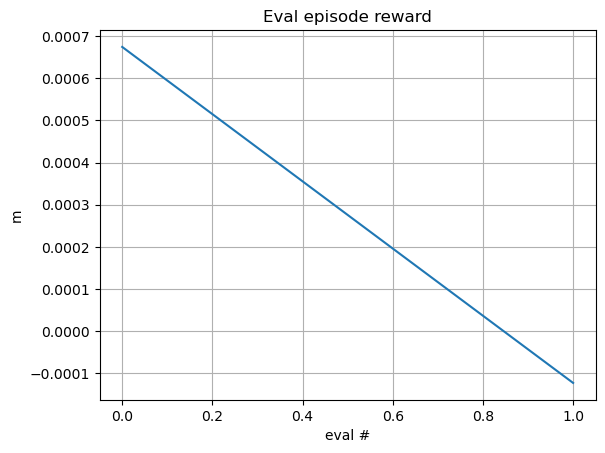

In [24]:
rew = [m[1].get('evaluation/episode_reward',
                m[1].get('eval/episode_reward',
                         m[1].get('eval/episode_return', 0.0)))
       for m in metrics_log]
plt.plot(rew); plt.title('Eval episode reward'); plt.xlabel('eval #'); plt.ylabel('m'); plt.grid(); plt.show()

### Visulazie MuJoCo

In [25]:
import time
import jax, jax.numpy as jnp
import numpy as np
from mujoco.glfw import glfw

from passive_walker.envs.mujoco_env import PassiveWalkerEnv

# ---------- 1.  grab the trained weights and inference fn -------------------
policy_fn = make_policy(params, deterministic=True)     

# ---------- 2.  launch a GUI MuJoCo sim ------------------------------------

mj_env = PassiveWalkerEnv(
    str(XML_PATH),
    simend          = 10.0,   
    use_nn_for_hip  = True,
    use_nn_for_knees= True,
    use_gui         = True,
    rng_seed=42
)

obs  = mj_env.reset()                       
key  = jax.random.PRNGKey(0)              
done = False
cum_reward = 0.0
t0 = time.time()
mj_env.render()

In [26]:
# ---------- 3.  control‑loop -------------------------------------------------
while not done and (not mj_env.window or not glfw.window_should_close(mj_env.window)):
    key, sub = jax.random.split(key)        
    act_jax, _ = policy_fn(jnp.array(obs), sub)
    act = np.asarray(act_jax, dtype=np.float32)  

    obs, reward, done, _ = mj_env.step(act)      # one physics step
    cum_reward += reward
    mj_env.render(mode="human")                  # draw frame (blocking)

print(f"\nEpisode finished in {time.time()-t0:.1f}s  |  total reward = {cum_reward:.2f}")
mj_env.close()


Episode finished in 21.1s  |  total reward = 252.47


# Full Enhanced PPO Experiment Suite

### Imports & Common Helpers

In [27]:
import brax.training.types as _bt

def _uint64_to_numpy(self):
    hi = int(self.hi)   # force Python int
    lo = int(self.lo)
    return (hi << 32) | lo

# override the methods in-place
#   _bt.UInt64.to_numpy = _uint64_to_numpy
#   _bt.UInt64.__int__    = lambda self: _uint64_to_numpy(self)

In [28]:
# core ----------------------------------------------------------------------
import os, time, json, hashlib, functools, itertools, pathlib, msgpack
import jax, brax  

from dataclasses import dataclass, asdict
from typing import Dict, Any, List

import numpy as np
import jax, jax.numpy as jnp
import flax
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import IPython.display as ipd
import math
import optax

# brax ----------------------------------------------------------------------
import brax
from brax.training.agents.ppo import train as ppo_train
from brax.training.agents import ppo as ppo_nets     # network helpers
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo.networks import make_ppo_networks, make_inference_fn

from brax.training import types

# reproducibility & JAX memory ----------------------------------------------
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# jax.config.update("jax_platform_name", "cpu")   # comment out for GPU/TPU
jax.config.update("jax_default_matmul_precision", "float32")  # optional
jax.config.update("jax_platform_name", "gpu")

print("JAX default device:", jax.devices()[0])
print("All JAX devices:", jax.devices())


JAX default device: cuda:0
All JAX devices: [CudaDevice(id=0)]


/home/yunusdanabas/miniconda3/envs/ens492/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the Sweep Grid

In [29]:
@dataclass
class SweepConfig:
    seed: int
    reward_scale: float
    lr: float
    arch: str              # NEW field: “small” or “deep”
    tag: str

    def __post_init__(self):
        self.seed         = int(self.seed)
        self.reward_scale = float(self.reward_scale)
        self.lr           = float(self.lr)

    def hash(self) -> str:
        return hashlib.sha1(json.dumps(asdict(self), sort_keys=True).encode())\
                     .hexdigest()[:8]


In [30]:
from itertools import product

seeds         = [0, 1, 2]                      # 3 seeds
reward_scales = [0.5, 1.0]                     # 2 reward multipliers
lrs           = [1e-3, 5e-4, 1e-4, 1e-5]       # 4 learning rates
archs         = ["tiny", "small", "medium",
                 "deep", "deepXL"]          # 5 network sizes

# 3 × 2 × 4 × 5 = 120 training jobs
grid = [
    SweepConfig(
        s, rs, lr, arch,
        tag=f"S{s}|R{rs}|LR{lr}|A{arch}"
    )
    for s, rs, lr, arch in product(seeds, reward_scales, lrs, archs)
]
print("Total runs:", len(grid))  # → 120


Total runs: 120


In [31]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 1.  Network factory – map every 'arch' string to widths                #
# ╚══════════════════════════════════════════════════════════════════════╝
def make_networks_factory(observation_size: int,
                          action_size: int,
                          cfg: SweepConfig,
                          preprocess_observations_fn=types.identity_observation_preprocessor):

    match cfg.arch:
        # ─── LIGHT MODELS ───────────────────────────────────────────────
        case "tiny":                       # ≈ 40 k params
            print("  using tiny networks")
            ph = (64, 64)                  # 2 layers of 64
            vh = (128, 128, 128)           # value net a bit deeper
        case "small":                      # ≈ 150 k params
            print("  using small networks")
            ph = (128, 128, 128, 128)      # 4 layers
            vh = (256,)*6
        case "medium":                     # ≈ 1 M params
            print("  using medium networks")
            ph = (256,)*6                  # 6 layers
            vh = (512,)*8

        # ─── HEAVY MODELS (unchanged) ──────────────────────────────────

        case "deep":                      # ≈ 4 M params
            print("  using large networks")
            ph = (512,)*6                  # 6 layers
            vh = (1024,)*8

        case "deepXL":
            print("  using deepXL networks")
            ph = (512,)*12
            vh = (1024,)*14

        case other:
            raise ValueError(f"Unknown arch {other}")

    return make_ppo_networks(
        observation_size           = observation_size,
        action_size                = action_size,
        policy_hidden_layer_sizes  = ph,
        value_hidden_layer_sizes   = vh,
        preprocess_observations_fn = preprocess_observations_fn,
        activation                 = jax.nn.tanh,
    )


In [32]:
from passive_walker.constants import RESULTS

RESULT_DIR = RESULTS / "brax" / "sweep_results"
RESULT_DIR.mkdir(exist_ok=True)

### Automated Training Loop

In [33]:
NUM_TIMESTEPS = 24 * 1024 * 1024          # 24 M updates ≈ twice your previous run
NUM_ENVS      = 128                       # more parallel simulators
EPISODE_LENGTH = 1024                      # 1k steps per episode
BATCH_SIZE    = 4096                      # ≈ NUM_ENVS × episode_length

def build_hp(cfg: SweepConfig, network_factory):
    return dict(
        num_timesteps   = NUM_TIMESTEPS,
        num_envs        = NUM_ENVS,
        episode_length  = EPISODE_LENGTH,
        batch_size      = BATCH_SIZE,
        reward_scaling  = cfg.reward_scale,
        learning_rate   = cfg.lr,
        seed            = cfg.seed,
        network_factory = network_factory,
        entropy_cost    = 1e-3,
        wrap_env        = True,
        num_evals       = 1,              # final eval only
    )

In [34]:
from tqdm.auto import tqdm
from brax.training.agents.ppo import train as ppo_train
import pathlib, msgpack, flax, jax


def run_one(cfg: SweepConfig):
    # build env
    env = BraxPassiveWalker(walker_sys)

    net_factory = lambda obs_sz, act_sz, **_: (
        make_networks_factory(obs_sz, act_sz, cfg)
    )

    hp = build_hp(cfg, net_factory)

    make_policy, params, metrics = ppo_train.train(
        environment = env,
        progress_fn = lambda *_: None,
        **hp
    )

    metrics_py = jax.tree_util.tree_map(
        lambda x: float(jax.device_get(x)) if isinstance(x, jax.Array) else x,
        metrics
    )
    params_bytes = flax.serialization.to_bytes(params)

    run_data = {
        "cfg":          asdict(cfg),
        "metrics":      metrics_py,
        "params_bytes": params_bytes,
    }
    out_file = RESULT_DIR / f"run_{cfg.hash()}.msgpack"
    with open(out_file, "wb") as f:
        msgpack.pack(run_data, f, use_bin_type=True)

    return {"file": str(out_file), **run_data}

In [35]:
all_results = []
for cfg in tqdm(grid, desc="Sweep", unit="run"):
    t0 = time.time()
    r  = run_one(cfg)
    r["walltime"] = time.time() - t0
    all_results.append(r)

Sweep:   0%|          | 0/120 [00:00<?, ?run/s]

  using tiny networks


Sweep:   1%|          | 1/120 [01:41<3:22:05, 101.89s/run]

  using small networks


Sweep:   2%|▏         | 2/120 [03:39<3:38:49, 111.26s/run]

  using medium networks


Sweep:   2%|▎         | 3/120 [06:42<4:41:04, 144.14s/run]

  using large networks


Sweep:   3%|▎         | 4/120 [12:48<7:27:25, 231.43s/run]

  using deepXL networks


Sweep:   4%|▍         | 5/120 [22:54<11:42:32, 366.54s/run]

  using tiny networks


Sweep:   5%|▌         | 6/120 [24:34<8:44:06, 275.85s/run] 

  using small networks


Sweep:   6%|▌         | 7/120 [26:33<7:03:18, 224.77s/run]

  using medium networks


Sweep:   7%|▋         | 8/120 [29:38<6:35:57, 212.12s/run]

  using large networks


Sweep:   8%|▊         | 9/120 [35:41<7:59:32, 259.21s/run]

  using deepXL networks


Sweep:   8%|▊         | 10/120 [45:43<11:09:09, 365.00s/run]

  using tiny networks


Sweep:   9%|▉         | 11/120 [47:18<8:32:54, 282.34s/run] 

  using small networks


Sweep:  10%|█         | 12/120 [49:14<6:57:23, 231.88s/run]

  using medium networks


Sweep:  11%|█         | 13/120 [52:13<6:25:00, 215.90s/run]

  using large networks


Sweep:  12%|█▏        | 14/120 [58:19<7:41:28, 261.22s/run]

  using deepXL networks


Sweep:  12%|█▎        | 15/120 [1:08:25<10:38:52, 365.07s/run]

  using tiny networks


Sweep:  13%|█▎        | 16/120 [1:10:01<8:12:25, 284.09s/run] 

  using small networks


Sweep:  14%|█▍        | 17/120 [1:12:00<6:42:19, 234.37s/run]

  using medium networks


Sweep:  15%|█▌        | 18/120 [1:15:01<6:10:59, 218.23s/run]

  using large networks


Sweep:  16%|█▌        | 19/120 [1:21:07<7:22:16, 262.74s/run]

  using deepXL networks


Sweep:  17%|█▋        | 20/120 [1:31:14<10:10:17, 366.18s/run]

  using tiny networks


Sweep:  18%|█▊        | 21/120 [1:32:52<7:51:12, 285.59s/run] 

  using small networks


Sweep:  18%|█▊        | 22/120 [1:34:48<6:23:12, 234.62s/run]

  using medium networks


Sweep:  19%|█▉        | 23/120 [1:37:52<5:55:04, 219.63s/run]

  using large networks


Sweep:  20%|██        | 24/120 [1:43:56<7:00:27, 262.78s/run]

  using deepXL networks


Sweep:  21%|██        | 25/120 [1:53:59<9:37:40, 364.85s/run]

  using tiny networks


Sweep:  22%|██▏       | 26/120 [1:55:42<7:28:35, 286.34s/run]

  using small networks


Sweep:  22%|██▎       | 27/120 [1:57:39<6:05:12, 235.62s/run]

  using medium networks


Sweep:  23%|██▎       | 28/120 [2:00:41<5:36:45, 219.62s/run]

  using large networks


Sweep:  24%|██▍       | 29/120 [2:06:47<6:39:26, 263.37s/run]

  using deepXL networks


Sweep:  25%|██▌       | 30/120 [2:16:56<9:10:27, 366.97s/run]

  using tiny networks


Sweep:  26%|██▌       | 31/120 [2:18:32<7:04:00, 285.85s/run]

  using small networks


Sweep:  27%|██▋       | 32/120 [2:20:27<5:43:57, 234.52s/run]

  using medium networks


Sweep:  28%|██▊       | 33/120 [2:23:28<5:16:36, 218.35s/run]

  using large networks


Sweep:  28%|██▊       | 34/120 [2:29:35<6:17:04, 263.07s/run]

  using deepXL networks


Sweep:  29%|██▉       | 35/120 [2:39:41<8:38:18, 365.87s/run]

  using tiny networks


Sweep:  30%|███       | 36/120 [2:41:17<6:39:03, 285.04s/run]

  using small networks


Sweep:  31%|███       | 37/120 [2:43:13<5:23:56, 234.17s/run]

  using medium networks


Sweep:  32%|███▏      | 38/120 [2:46:14<4:58:22, 218.32s/run]

  using large networks


Sweep:  32%|███▎      | 39/120 [2:52:24<5:56:10, 263.83s/run]

  using deepXL networks


Sweep:  33%|███▎      | 40/120 [3:02:32<8:09:25, 367.07s/run]

  using tiny networks


Sweep:  34%|███▍      | 41/120 [3:04:11<6:17:15, 286.52s/run]

  using small networks


Sweep:  35%|███▌      | 42/120 [3:06:08<5:06:24, 235.70s/run]

  using medium networks


Sweep:  36%|███▌      | 43/120 [3:09:09<4:41:40, 219.48s/run]

  using large networks


Sweep:  37%|███▋      | 44/120 [3:15:13<5:32:43, 262.68s/run]

  using deepXL networks


Sweep:  38%|███▊      | 45/120 [3:25:20<7:37:33, 366.04s/run]

  using tiny networks


Sweep:  38%|███▊      | 46/120 [3:27:00<5:53:08, 286.33s/run]

  using small networks


Sweep:  39%|███▉      | 47/120 [3:29:00<4:47:41, 236.46s/run]

  using medium networks


Sweep:  40%|████      | 48/120 [3:32:05<4:25:06, 220.92s/run]

  using large networks


Sweep:  41%|████      | 49/120 [3:38:10<5:12:34, 264.15s/run]

  using deepXL networks


Sweep:  42%|████▏     | 50/120 [3:48:15<7:07:35, 366.51s/run]

  using tiny networks


Sweep:  42%|████▎     | 51/120 [3:50:02<5:31:43, 288.46s/run]

  using small networks


Sweep:  43%|████▎     | 52/120 [3:52:00<4:29:09, 237.50s/run]

  using medium networks


Sweep:  44%|████▍     | 53/120 [3:55:03<4:06:58, 221.17s/run]

  using large networks


Sweep:  45%|████▌     | 54/120 [4:01:09<4:51:02, 264.59s/run]

  using deepXL networks


Sweep:  46%|████▌     | 55/120 [4:11:17<6:38:17, 367.66s/run]

  using tiny networks


Sweep:  47%|████▋     | 56/120 [4:12:58<5:06:40, 287.51s/run]

  using small networks


Sweep:  48%|████▊     | 57/120 [4:14:56<4:08:24, 236.58s/run]

  using medium networks


Sweep:  48%|████▊     | 58/120 [4:18:08<3:50:51, 223.41s/run]

  using large networks


Sweep:  49%|████▉     | 59/120 [4:24:16<4:31:03, 266.61s/run]

  using deepXL networks


Sweep:  50%|█████     | 60/120 [4:34:24<6:09:03, 369.06s/run]

  using tiny networks


Sweep:  51%|█████     | 61/120 [4:36:03<4:43:23, 288.19s/run]

  using small networks


Sweep:  52%|█████▏    | 62/120 [4:38:02<3:49:17, 237.20s/run]

  using medium networks


Sweep:  52%|█████▎    | 63/120 [4:41:04<3:29:47, 220.83s/run]

  using large networks


Sweep:  53%|█████▎    | 64/120 [4:47:08<4:06:05, 263.68s/run]

  using deepXL networks


Sweep:  54%|█████▍    | 65/120 [4:57:16<5:36:31, 367.12s/run]

  using tiny networks


Sweep:  55%|█████▌    | 66/120 [4:58:55<4:17:48, 286.45s/run]

  using small networks


Sweep:  56%|█████▌    | 67/120 [5:00:52<3:28:09, 235.65s/run]

  using medium networks


Sweep:  57%|█████▋    | 68/120 [5:03:54<3:10:27, 219.76s/run]

  using large networks


Sweep:  57%|█████▊    | 69/120 [5:09:59<3:43:47, 263.28s/run]

  using deepXL networks


Sweep:  58%|█████▊    | 70/120 [5:20:03<5:04:24, 365.29s/run]

  using tiny networks


Sweep:  59%|█████▉    | 71/120 [5:21:42<3:53:08, 285.48s/run]

  using small networks


Sweep:  60%|██████    | 72/120 [5:23:40<3:08:06, 235.14s/run]

  using medium networks


Sweep:  61%|██████    | 73/120 [5:26:50<2:53:46, 221.85s/run]

  using large networks


Sweep:  62%|██████▏   | 74/120 [5:32:55<3:23:02, 264.83s/run]

  using deepXL networks


Sweep:  62%|██████▎   | 75/120 [5:43:02<4:35:36, 367.48s/run]

  using tiny networks


Sweep:  63%|██████▎   | 76/120 [5:44:42<3:30:31, 287.09s/run]

  using small networks


Sweep:  64%|██████▍   | 77/120 [5:46:40<2:49:29, 236.51s/run]

  using medium networks


Sweep:  65%|██████▌   | 78/120 [5:49:42<2:33:59, 219.99s/run]

  using large networks


Sweep:  66%|██████▌   | 79/120 [5:55:46<2:59:53, 263.27s/run]

  using deepXL networks


Sweep:  67%|██████▋   | 80/120 [6:05:54<4:04:21, 366.53s/run]

  using tiny networks


Sweep:  68%|██████▊   | 81/120 [6:07:40<3:07:24, 288.33s/run]

  using small networks


Sweep:  68%|██████▊   | 82/120 [6:09:36<2:30:01, 236.89s/run]

  using medium networks


Sweep:  69%|██████▉   | 83/120 [6:12:38<2:15:50, 220.28s/run]

  using large networks


Sweep:  70%|███████   | 84/120 [6:18:41<2:37:55, 263.22s/run]

  using deepXL networks


Sweep:  71%|███████   | 85/120 [6:28:44<3:32:55, 365.02s/run]

  using tiny networks


Sweep:  72%|███████▏  | 86/120 [6:30:22<2:41:29, 284.97s/run]

  using small networks


Sweep:  72%|███████▎  | 87/120 [6:32:19<2:09:00, 234.56s/run]

  using medium networks


Sweep:  73%|███████▎  | 88/120 [6:35:29<1:57:58, 221.20s/run]

  using large networks


Sweep:  74%|███████▍  | 89/120 [6:41:34<2:16:36, 264.41s/run]

  using deepXL networks


Sweep:  75%|███████▌  | 90/120 [6:51:41<3:03:34, 367.17s/run]

  using tiny networks


Sweep:  76%|███████▌  | 91/120 [6:53:19<2:18:22, 286.30s/run]

  using small networks


Sweep:  77%|███████▋  | 92/120 [6:55:16<1:49:57, 235.63s/run]

  using medium networks


Sweep:  78%|███████▊  | 93/120 [6:58:18<1:38:44, 219.41s/run]

  using large networks


Sweep:  78%|███████▊  | 94/120 [7:04:23<1:54:03, 263.22s/run]

  using deepXL networks


Sweep:  79%|███████▉  | 95/120 [7:14:30<2:32:36, 366.27s/run]

  using tiny networks


Sweep:  80%|████████  | 96/120 [7:16:18<1:55:31, 288.81s/run]

  using small networks


Sweep:  81%|████████  | 97/120 [7:18:16<1:31:07, 237.72s/run]

  using medium networks


Sweep:  82%|████████▏ | 98/120 [7:21:20<1:21:12, 221.50s/run]

  using large networks


Sweep:  82%|████████▎ | 99/120 [7:27:26<1:32:38, 264.69s/run]

  using deepXL networks


Sweep:  83%|████████▎ | 100/120 [7:37:35<2:02:40, 368.00s/run]

  using tiny networks


Sweep:  84%|████████▍ | 101/120 [7:39:13<1:30:53, 287.01s/run]

  using small networks


Sweep:  85%|████████▌ | 102/120 [7:41:09<1:10:46, 235.94s/run]

  using medium networks


Sweep:  86%|████████▌ | 103/120 [7:44:22<1:03:07, 222.79s/run]

  using large networks


Sweep:  87%|████████▋ | 104/120 [7:50:54<1:12:56, 273.54s/run]

  using deepXL networks


Sweep:  88%|████████▊ | 105/120 [8:02:56<1:42:05, 408.34s/run]

  using tiny networks


Sweep:  88%|████████▊ | 106/120 [8:04:43<1:14:08, 317.72s/run]

  using small networks


Sweep:  89%|████████▉ | 107/120 [8:06:37<55:38, 256.81s/run]  

  using medium networks


Sweep:  90%|█████████ | 108/120 [8:10:03<48:15, 241.31s/run]

  using large networks


Sweep:  91%|█████████ | 109/120 [8:17:12<54:34, 297.66s/run]

  using deepXL networks


Sweep:  92%|█████████▏| 110/120 [8:28:38<1:09:02, 414.24s/run]

  using tiny networks


Sweep:  92%|█████████▎| 111/120 [8:30:37<48:50, 325.66s/run]  

  using small networks


Sweep:  93%|█████████▎| 112/120 [8:32:40<35:18, 264.83s/run]

  using medium networks


Sweep:  94%|█████████▍| 113/120 [8:35:52<28:21, 243.10s/run]

  using large networks


Sweep:  95%|█████████▌| 114/120 [8:42:49<29:31, 295.29s/run]

  using deepXL networks


Sweep:  96%|█████████▌| 115/120 [8:53:13<32:48, 393.80s/run]

  using tiny networks


Sweep:  97%|█████████▋| 116/120 [8:54:52<20:21, 305.32s/run]

  using small networks


Sweep:  98%|█████████▊| 117/120 [8:56:52<12:29, 249.67s/run]

  using medium networks


Sweep:  98%|█████████▊| 118/120 [8:59:58<07:41, 230.62s/run]

  using large networks


Sweep:  99%|█████████▉| 119/120 [9:06:21<04:36, 276.51s/run]

  using deepXL networks


Sweep: 100%|██████████| 120/120 [9:16:43<00:00, 278.37s/run]


### Aggregate & Plot

,seed,reward_scale,lr,tag,walltime,reward
0,0,0.5,0.00100,S0|R0.5|LR0.001|Atiny,101.891935,0.099089
1,0,0.5,0.00100,S0|R0.5|LR0.001|Asmall,117.821274,0.028981
2,0,0.5,0.00100,S0|R0.5|LR0.001|Amedium,183.267111,-0.093348
3,0,0.5,0.00100,S0|R0.5|LR0.001|Adeep,365.241978,0.017676
4,0,0.5,0.00100,S0|R0.5|LR0.001|AdeepXL,606.101465,0.276140
...,...,...,...,...,...,...
115,2,1.0,0.00001,S2|R1.0|LR1e-05|Atiny,98.875457,0.269704
116,2,1.0,0.00001,S2|R1.0|LR1e-05|Asmall,119.814648,0.081821
117,2,1.0,0.00001,S2|R1.0|LR1e-05|Amedium,186.183223,-0.036795
118,2,1.0,0.00001,S2|R1.0|LR1e-05|Adeep,383.582678,0.054022


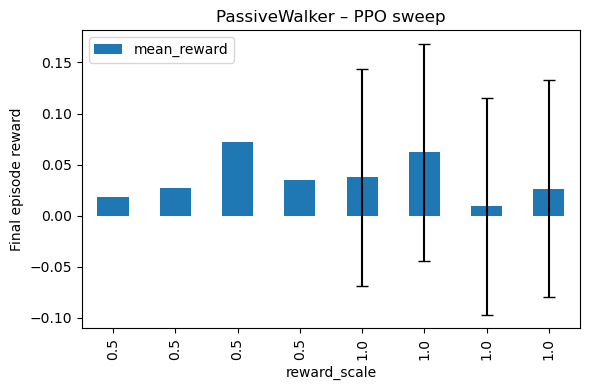

In [36]:
# ─── build raw DataFrame ───────────────────────────────────────────────────
raw_df = pd.DataFrame(all_results)

# ─── flatten the nested cfg dict into its own columns ───────────────────────
cfg_df = pd.DataFrame(raw_df["cfg"].tolist())
df     = pd.concat([cfg_df, raw_df.drop(columns=["cfg"])], axis=1)

# ─── extract a single scalar reward from whatever key exists ───────────────
def extract_reward(m):
    return (
        m.get("evaluation/episode_reward")
      or m.get("eval/episode_reward")
      or m.get("reward")
      or next(iter(m.values()))
    )
df["reward"] = df["metrics"].apply(extract_reward)

# ─── now you truly have seed, reward_scale, etc. ───────────────────────────
display(df[["seed", "reward_scale", "lr", "tag", "walltime", "reward"]])

# ─── bar-plot: average over seeds ──────────────────────────────────────────
plot_df = (
    df
    .groupby(["reward_scale", "lr"], as_index=False)
    .agg(mean_reward=("reward","mean"),
         std_reward =("reward","std"))
)

fig, ax = plt.subplots(figsize=(6,4))
plot_df.plot.bar(x="reward_scale", y="mean_reward",
                 yerr=plot_df["std_reward"], capsize=4, ax=ax)
ax.set_ylabel("Final episode reward")
ax.set_title("PassiveWalker – PPO sweep")
plt.tight_layout()

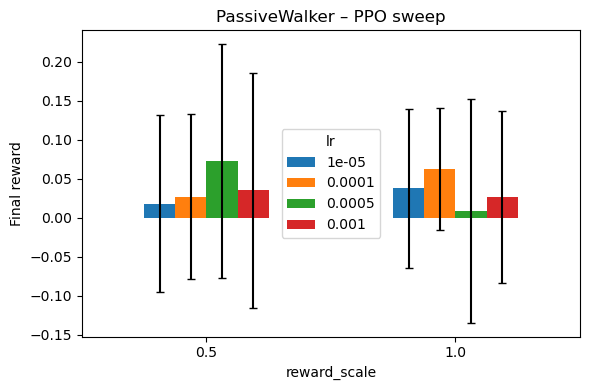

In [37]:
plot_df = (df.groupby(["reward_scale","lr"],as_index=False)
             .agg(mean_reward=("reward","mean"), std_reward=("reward","std")))

ax = plot_df.pivot(index="reward_scale",columns="lr",values="mean_reward").plot.bar(
        yerr=plot_df.pivot(index="reward_scale",columns="lr",values="std_reward"),
        capsize=3, rot=0, figsize=(6,4))
ax.set_ylabel("Final reward"); ax.set_title("PassiveWalker – PPO sweep"); plt.tight_layout()

### Export Best Policy

In [38]:
MODEL_PATH = None                         # <- set path string for custom

if MODEL_PATH is None:
    best_row  = df.loc[df.reward.idxmax()]
    MODEL_PATH = best_row["file"]
    print("Auto‑selected best run →", MODEL_PATH)
else:
    MODEL_PATH = str(pathlib.Path(MODEL_PATH).expanduser())

Auto‑selected best run → /home/yunusdanabas/passive_walker_rl/results/brax/sweep_results/run_1ee2e7b2.msgpack


In [39]:
# ---------- load ----------------------------------------------------------
saved        = msgpack.unpack(open(MODEL_PATH, "rb"), raw=False)
cfg          = SweepConfig(**saved["cfg"])
params_bytes = saved["params_bytes"]   # ★ grab the raw bytes
# print("Reward:", saved["metrics"]["reward"])

In [40]:
# ---------- rebuild policy -----------------------------------------------
env_vis = BraxPassiveWalker(walker_sys)

# ─── build your PPONetworks & policy factory ────────────────────────────
ppon = make_networks_factory(env_vis.obs_size, env_vis.act_size, cfg)
policy_factory = make_inference_fn(ppon)

# ─── init dummy params & assemble pytree shape ───────────────────────────
init_pol = ppon.policy_network.init(jax.random.PRNGKey(0))
init_val = ppon.value_network.init(jax.random.PRNGKey(1))
init_params = (None, init_pol, init_val)   # no obs-normalizer in our toy setup

# ─── load your saved bytes into that pytree ───────────────────────────────
params = flax.serialization.from_bytes(init_params, params_bytes)

# ─── build a deterministic policy fn ─────────────────────────────────────
policy = policy_factory(params, deterministic=True)


  using medium networks


# MuJoCo‑Based Visualization

In [43]:
import msgpack, flax
import jax, jax.numpy as jnp
import numpy as np
from mujoco.glfw import glfw
from passive_walker.envs.mujoco_env import PassiveWalkerEnv
from pathlib import Path
from brax.training.agents.ppo.networks import make_ppo_networks, make_inference_fn

from passive_walker.constants import RESULTS

# ——— load the best run from sweep_results ————————————————
MODEL_PATH = RESULTS / "brax" / "sweep_results" / "run_1ee2e7b2.msgpack"   # ← or override this
saved       = msgpack.unpack(open(MODEL_PATH, "rb"), raw=False)
cfg         = SweepConfig(**saved["cfg"])
params_bytes= saved["params_bytes"]
print(f"Visualizing {cfg.tag}")

Visualizing S2|R0.5|LR0.001|Amedium


In [44]:
# We only use the Brax network to get the right shapes
env_brax    = BraxPassiveWalker(walker_sys)
ppo_nets    = make_networks_factory(env_brax.obs_size, env_brax.act_size, cfg)
policy_maker= make_inference_fn(ppo_nets)

# init an empty params pytree then load your saved bytes
init_pol    = ppo_nets.policy_network.init(jax.random.PRNGKey(0))
init_val    = ppo_nets.value_network.init(jax.random.PRNGKey(1))
init_tree   = (None, init_pol, init_val)
params      = flax.serialization.from_bytes(init_tree, params_bytes)

# deterministic policy
policy      = policy_maker(params, deterministic=True)

  using medium networks


In [46]:
# ——— launch MuJoCo + render the rollout ——————————————————————
from passive_walker.constants import XML_PATH

mj_env   = PassiveWalkerEnv(str(XML_PATH),
                            simend=20.0,
                            use_nn_for_hip=True,
                            use_nn_for_knees=True,
                            use_gui=True)

# run
obs  = mj_env.reset()
key  = jax.random.PRNGKey(0)
done = False
total_reward = 0.0

while not done and not glfw.window_should_close(mj_env.window):
    key, sub = jax.random.split(key)
    # policy expects a jax array of shape (11,)
    act_jax, _ = policy(jnp.array(obs), sub)
    act = np.array(act_jax, dtype=np.float32)     # back to NumPy
    obs, r, done, info = mj_env.step(act)
    total_reward += r
    mj_env.render(mode="human")

print("Total reward:", total_reward)
mj_env.close()


/home/yunusdanabas/miniconda3/envs/ens492/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Total reward: 99.19197772443295
